In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm

from scipy.interpolate import griddata

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)

cuda:0


In [3]:
def valuation(type_offender, type_defender, t):
    v_1 = type_offender * (t - t ** 2 / 2)
    v_2 = type_defender * (1 - t)
    
    return v_1, v_2


def loss_function(value):
    return -value


In [4]:
class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        self.u_offender = Variable(torch.Tensor([1.0]), requires_grad=False).cuda() 
        self.u_defender = torch.nn.Parameter(torch.Tensor([1.000]), requires_grad=True).cuda() 
        num_input=1
        num_hidden=100
        num_output=1
        
        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_3 = torch.nn.Linear(num_hidden, num_hidden)
        self.output   = torch.nn.Linear(num_hidden, num_output)
        
        

    def forward(self, x, type_offender, type_defender): # type_offender val_offender   ;  type_defender val_defender

        h1 = torch.sigmoid(self.hidden_0(x))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.relu_(self.hidden_2(h2))
        h4 = torch.sigmoid(self.hidden_3(h3))
        ao = self.output(h4)

        value_offender, value_defender = valuation(type_offender, type_defender, x)
        temp_val_offender = (value_offender * (self.u_offender).cuda()).cuda() 
        temp_val_defender = (value_defender * (self.u_defender).cuda()).cuda()
        
        
        val_offender = temp_val_offender + ao
        val_defender = temp_val_defender + ao
        #print(o.grad_fn,temp_val_defender.grad_fn)
        #print(val_offender)
        
        max_offender, max_t_offender = val_offender.max(0)
        max_defender, max_t_defender = val_defender.max(0)
        
        
        
        #print("max_offender: " ,max_offender,max_offender.grad)
        
        val_sum = val_offender + val_defender - ao
        max_val, t_end = val_sum.max(0) 

        end_val_offender = val_offender[int(t_end)].cuda()
        end_val_defender = val_defender[int(t_end)].cuda()
        pay_offender = (max_defender - end_val_defender) / (self.u_offender).cuda()
        pay_defender = (max_offender - end_val_offender) / (self.u_defender).cuda()
        
#         if((max_defender - end_val_defender) / self.u_offender > value_offender[int(t_end)]):
#             print("error: payment offender",(max_defender - end_val_defender) / self.u_offender,value_offender[int(t_end)]);
#         if((max_offender - end_val_offender) / self.u_defender > value_defender[int(t_end)]):
#             print("error: payment defender",(max_offender - end_val_offender) / self.u_defender,value_defender[int(t_end)]);
        
        payment = pay_offender + pay_defender

        return payment, ao, x[int(t_end)], self.u_offender ,self.u_defender




In [5]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
        

In [6]:
random.seed(2000)
torch.manual_seed(256)
time_frame = np.linspace(0, 1, 101)
time_frame = np.expand_dims(time_frame, axis=1)

time_frame = torch.from_numpy(time_frame).cuda()
time_frame = time_frame.type(torch.float32)
time_frame.requires_gard = False
net  = Net()
net.apply(weight_init)
print(time_frame)

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900],
        [0.1000],
        [0.1100],
        [0.1200],
        [0.1300],
        [0.1400],
        [0.1500],
        [0.1600],
        [0.1700],
        [0.1800],
        [0.1900],
        [0.2000],
        [0.2100],
        [0.2200],
        [0.2300],
        [0.2400],
        [0.2500],
        [0.2600],
        [0.2700],
        [0.2800],
        [0.2900],
        [0.3000],
        [0.3100],
        [0.3200],
        [0.3300],
        [0.3400],
        [0.3500],
        [0.3600],
        [0.3700],
        [0.3800],
        [0.3900],
        [0.4000],
        [0.4100],
        [0.4200],
        [0.4300],
        [0.4400],
        [0.4500],
        [0.4600],
        [0.4700],
        [0.4800],
        [0.4900],
        [0.5000],
        [0.5100],
        [0.5200],
        [0.5300],
        [0.5400],
        [0

[391.1958048    8.07743806]
[[271.69199845  12.05608554]
 [ 85.35414143   6.78185943]
 [ 92.12115161   8.22734879]
 ...
 [303.15368136   3.59778968]
 [191.24357187   7.38312562]
 [163.77016144   3.63757603]]
[271.69199845  85.35414143  92.12115161 ... 303.15368136 191.24357187
 163.77016144]


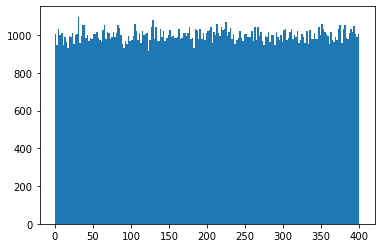

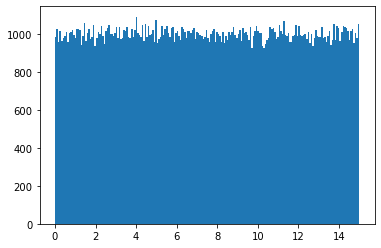

180000
[[1.01623022e+02 1.45134801e+01]
 [3.58692764e+02 2.38606712e+00]
 [2.95406096e+02 1.38418421e+01]
 [2.57091259e+02 6.59259653e+00]
 [6.22504093e+01 1.16473372e+01]
 [1.82995642e+02 7.06279225e+00]
 [1.72626895e+02 3.55264040e+00]
 [3.41189650e+02 1.17431676e+01]
 [2.48701560e+02 8.16909651e+00]
 [2.88651362e+01 3.47370677e-01]
 [2.97685552e+02 1.04270591e+01]
 [1.06923335e+02 8.71202509e+00]
 [3.09082895e+01 6.52370323e+00]
 [2.39770819e+02 1.13704165e+01]
 [2.69825039e+01 7.51637857e+00]
 [8.04731585e+01 9.13683528e+00]
 [3.14530904e+02 3.10470423e+00]
 [3.64684973e+02 1.14127070e+01]
 [2.75471190e+02 1.03352282e+01]
 [1.87554542e+02 4.51921096e+00]
 [2.13081019e+02 6.58091709e+00]
 [3.45864064e+02 5.45856074e+00]
 [2.61937827e+02 8.83745731e+00]
 [3.79090481e+02 1.47907281e+01]
 [3.46618991e+02 1.28660272e+01]
 [1.36808661e+01 9.10215798e+00]
 [2.28880074e+02 6.29833958e+00]
 [2.79569145e+02 1.16590495e+01]
 [3.21707352e+02 1.18319849e+01]
 [3.10470455e+02 3.41400851e+00]
 [1

In [7]:
agent_number_n=2
seed = 7
np.random.seed(seed)
exec(open('distribution1item_uniform.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.1, random_state=seed)

X_train=np.array(X_train)
X_test=np.array(X_test)
dataset_size = len(X_train)
print(dataset_size)
print(X_train[:100])
print(len(X_test))



In [8]:
index_train=[]
batch_length = int(10)
t_off = np.linspace(0, 400, batch_length)
t_def = np.linspace(0, 15, batch_length)
index_train = []
for i in range(batch_length):
    for j in range(batch_length):
        index_train.append([t_off[i], t_def[j]])

In [9]:
net = torch.load("AMA_net_large_u=1_1")

#net.u_defender = torch.nn.Parameter(torch.Tensor([1.005]), requires_grad=True)

In [10]:
net.to(dev)

Net(
  (hidden_0): Linear(in_features=1, out_features=100, bias=True)
  (hidden_1): Linear(in_features=100, out_features=100, bias=True)
  (hidden_2): Linear(in_features=100, out_features=100, bias=True)
  (hidden_3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
)

In [11]:

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.002)
optimizer = opt.Adam(net.parameters(), lr=0.0002)

batch_size = 16
echo = 10000

In [12]:
for i in range(int(1)):

    # offender_types = []
    # defender_types = []
    loss_sum = 0
    denominator =0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    for j in range(batch_size):
        index_random = random.randint(0,len(X_train)-1)
        pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            X_train[index_random][0], X_train[index_random][1])
        loss_sum += pay
        
        denominator+=1
    


        

    
    
    optimizer.zero_grad()
    #loss = torch.square(loss_function(loss_sum / denominator) + 52)
    loss = loss_function(loss_sum / denominator)
    
    #loss.backward()
    
    

    #optimizer.step()
    
        


    if i % 100 == 0:
        loss_sum1=0
        denominator1=0
        for j in range(10000):
            index_random = random.randint(0,len(X_train)-1)
            pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            X_train[index_random][0], X_train[index_random][1])
            loss_sum1 += float(pay)
            denominator1+=1
        loss_average=float(loss_sum1 / denominator1)

        #offender_types = sum(offender_types) / batch_size
        #defender_types = sum(defender_types) / batch_size
        #print(loss_sum.data)
        #print(offender_types, defender_types, loss_sum)
        #print("curve for o: ",curve)
        print("batch: %.5f " % float(loss_sum/denominator),'，sum_average: %.5f' % float(loss_average),'u_def %.5f' % float(uu_defender))
        #plt.pause(0.03)
        if(loss_average>50.2):
            break;
    

batch: 44.13803  ，sum_average: 49.53766 u_def 1.00000


loss_sum: 44.13803 44.138031005859375
tensor([0.0100], device='cuda:0')


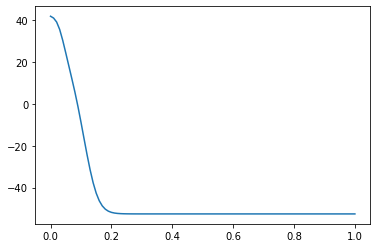

In [13]:
print("loss_sum: %.5f" % -loss , float(loss_sum/denominator))

print(o_star)
plt.cla()
#plt.axvline(o_star.cpu().data,color ='red')
plt.plot(time_frame.cpu().data.numpy(), curve_o.cpu().data.numpy())




In [14]:
loss_sum1=0
Z_payment=[]
Z_o_star=[]
for i in range(len(X_test)):
    pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            X_test[i][0], X_test[i][1])
    Z_payment.append(float(pay))
    Z_o_star.append(float(o_star))
    loss_sum1 += float(pay)

print(len(X_test))
print("test_average: %.5f" % (loss_sum1/len(X_test) ))

20000
test_average: 50.31178


In [15]:
#torch.save(net, "AMA_net_large_u=1_1")

In [16]:
X_test=np.array(X_test)
Z_payment=np.array(Z_payment)
Z_o_star=np.array(Z_o_star)
print(len(X_test[:,0]))

print(len(Z_payment))

20000
20000


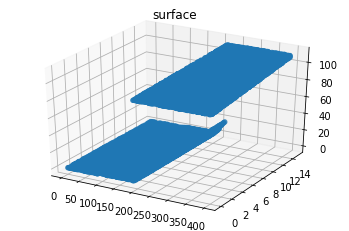

In [17]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')


ax.scatter3D(X_test[:,0], X_test[:,1], Z_payment,cmap='Greens');


#ax.plot_surface(X_test[:,0], X_test[:,1], Z_payment)
ax.set_title('surface');


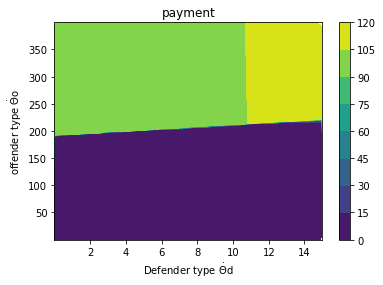

In [18]:
fig = plt.figure()
contour = plt.tricontourf(X_test[:,1],  X_test[:,0], Z_payment
              
               #cmap = cm.get_cmap(name='jet')
                         )
fig.colorbar(contour)
plt.title('payment')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")

fig.savefig('3D.png')
plt.show()

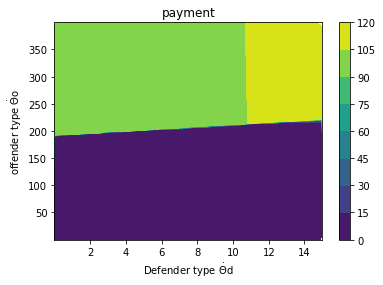

In [19]:
fig = plt.figure()
contour = plt.tricontourf(X_test[:,1],  X_test[:,0], Z_payment,
              
               #cmap = cm.get_cmap(name='jet')
                         )
fig.colorbar(contour)
plt.title('payment')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")

fig.savefig('3D.png')
plt.show()

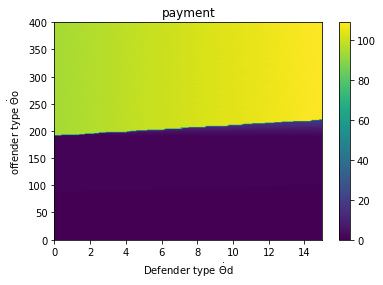

In [20]:
grid_x, grid_y = np.mgrid[0:15:400j, 400:0:400j]
points =np.reshape([X_test[:,1],X_test[:,0]],(2,-1))
points = np.transpose(points)
grid_z0 = griddata(points, Z_payment, (grid_x, grid_y), method='nearest')
im =plt.imshow(grid_z0.T, extent=(0,15,0,400) , aspect='auto',interpolation='bilinear')
plt.colorbar(im)
plt.title('payment')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")
plt.show()

In [21]:
print(Z_o_star.max())

1.0


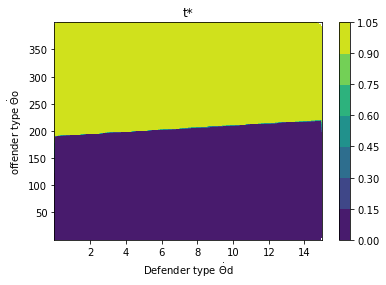

In [22]:
fig = plt.figure()
contour = plt.tricontourf(X_test[:,1],  X_test[:,0],  Z_o_star
              
               #cmap = cm.get_cmap(name='jet')
                         )
fig.colorbar(contour)
plt.title('t*')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")

plt.show()

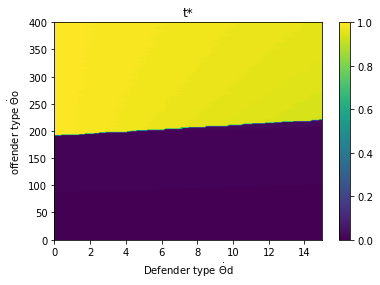

In [23]:
grid_x, grid_y = np.mgrid[0:15:400j, 400:0:400j]

points =np.reshape([X_test[:,1],X_test[:,0]],(2,-1))

points = np.transpose(points)

grid_z1 = griddata(points, Z_o_star, (grid_x, grid_y), method='nearest')


im =plt.imshow(grid_z1.T, extent=(0,15,0,400) , aspect='auto',interpolation='bilinear')
plt.colorbar(im)
plt.title('t*')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")
plt.show()

In [24]:
print(X_test[i][0])

342.90589156092847


In [25]:
li=np.linspace(0,15,5001)
Z_o_star_100=[]
Z_o_star_200=[]
Z_o_star_300=[]
for sample in li:
        pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            100, sample)
        Z_o_star_100.append(float(o_star))
        
        pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            200, sample)
        Z_o_star_200.append(float(o_star))
        
        pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            300, sample)
        Z_o_star_300.append(float(o_star))

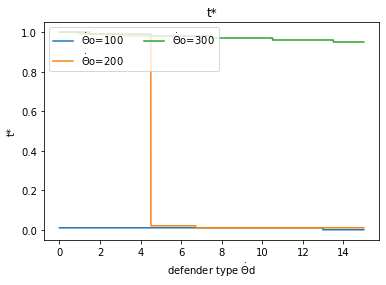

In [26]:
plt.cla()
plt.plot(li, Z_o_star_100,label="$\dot{\Theta}$o=100")
plt.plot(li, Z_o_star_200,label="$\dot{\Theta}$o=200")
plt.plot(li, Z_o_star_300,label="$\dot{\Theta}$o=300")
plt.title('t*')
plt.xlabel(r"defender type $\dot{\Theta}$d")
plt.ylabel(r't*')
plt.legend(loc=2, ncol=2)

plt.show()

In [27]:
li=np.linspace(0,400,5001)
Z_o_star_5=[]
Z_o_star_9=[]
Z_o_star_13=[]

for sample in li:
    pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            sample, 5)
    Z_o_star_5.append(float(o_star))
    
    pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            sample, 9)
    Z_o_star_9.append(float(o_star))
    
    pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            sample, 13)
    Z_o_star_13.append(float(o_star))
    



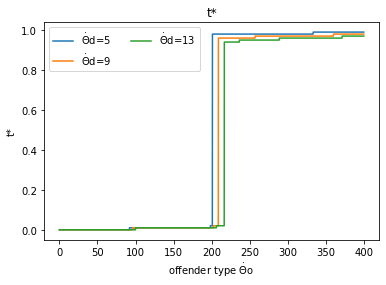

In [28]:
plt.cla()
plt.plot(li, Z_o_star_5,label="$\dot{\Theta}$d=5")
plt.plot(li, Z_o_star_9,label="$\dot{\Theta}$d=9")
plt.plot(li, Z_o_star_13,label="$\dot{\Theta}$d=13")
plt.title('t*')
plt.xlabel(r"offender type $\dot{\Theta}$o")
plt.ylabel(r"t*")
plt.legend(loc=2, ncol=2)
plt.show()

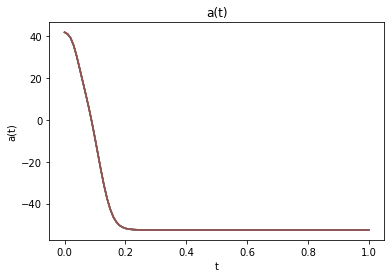

In [29]:
li=np.linspace(0,400,5001)
Z_o_star_1=[]
Z_o_star_2=[]
Z_o_star_3=[]

pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            80, 8)
Z_o_star_1=curve_o.cpu().data.numpy()
    
pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            130, 8)
Z_o_star_2=curve_o.cpu().data.numpy()
    
pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            180, 8)
Z_o_star_3=curve_o.cpu().data.numpy()
    

plt.cla()
plt.plot(time_frame.cpu().data.numpy(), Z_o_star_1,label="$\dot{\Theta}$d=1")
plt.plot(time_frame.cpu().data.numpy(), Z_o_star_2,label="$\dot{\Theta}$d=2")
plt.plot(time_frame.cpu().data.numpy(), Z_o_star_3,label="$\dot{\Theta}$d=3")


pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            320, 5)
Z_o_star_1=curve_o.cpu().data.numpy()
    
pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            320, 9)
Z_o_star_2=curve_o.cpu().data.numpy()
    
pay , curve_o, o_star, uu_offender, uu_defender = net(time_frame, 
                            320, 13)
Z_o_star_3=curve_o.cpu().data.numpy()
    

plt.plot(time_frame.cpu().data.numpy(), Z_o_star_1,label="$\dot{\Theta}$d=1")
plt.plot(time_frame.cpu().data.numpy(), Z_o_star_2,label="$\dot{\Theta}$d=2")
plt.plot(time_frame.cpu().data.numpy(), Z_o_star_3,label="$\dot{\Theta}$d=3")
plt.title('a(t)')
plt.xlabel(r"t")
plt.ylabel(r"a(t)")
#plt.legend(loc=2, ncol=2)
plt.show()

Optimal function o* = argmax_o { (2 theta_O - 400)(o-o*o/2) + (2 theta_D - 15)(1-o)  }

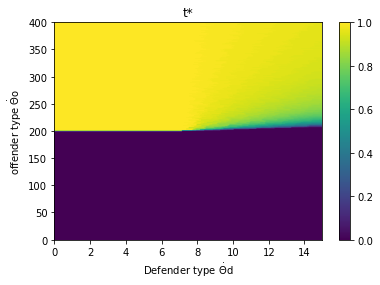

In [30]:
o_frame = np.linspace(0.0,1.0,101)
Z_o_star_opt=[]
for i in range(len(X_test)):
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * X_test[i,0] - 400)*(o-o*o/2) + (2 * X_test[i,1] - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_opt.append(temp_id)
    
#o* = argmax_o { (2 * theta_O - 400)(o-o*o/2) + (2 * theta_D - 15)(1-o)  }

grid_x, grid_y = np.mgrid[0:15:400j, 400:0:400j]

points =np.reshape([X_test[:,1],X_test[:,0]],(2,-1))

points = np.transpose(points)

grid_z2 = griddata(points, Z_o_star_opt, (grid_x, grid_y), method='nearest')


im =plt.imshow(grid_z2.T, extent=(0,15,0,400) , aspect='auto',interpolation='bilinear')
plt.colorbar(im)
plt.title('t*')
plt.xlabel(r"Defender type $\dot{\Theta}$d")
plt.ylabel(r"offender type $\dot{\Theta}$o")
plt.show()

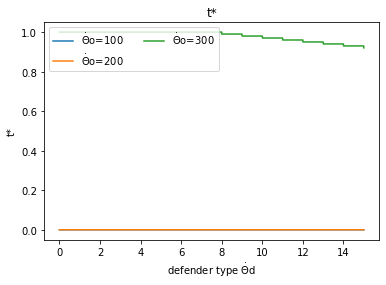

In [31]:
li=np.linspace(0,15,5001)
Z_o_star_100=[]
Z_o_star_200=[]
Z_o_star_300=[]

for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * 100 - 400)*(o-o*o/2) + (2 * sample - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_100.append(temp_id)
    
for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * 200 - 400)*(o-o*o/2) + (2 * sample - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_200.append(temp_id)
    
for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * 300 - 400)*(o-o*o/2) + (2 * sample - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_300.append(temp_id)
        
plt.cla()
plt.plot(li, Z_o_star_100,label="$\dot{\Theta}$o=100")
plt.plot(li, Z_o_star_200,label="$\dot{\Theta}$o=200")
plt.plot(li, Z_o_star_300,label="$\dot{\Theta}$o=300")
plt.title('t*')
plt.xlabel(r"defender type $\dot{\Theta}$d")
plt.ylabel(r't*')
plt.legend(loc=2, ncol=2)
plt.show()

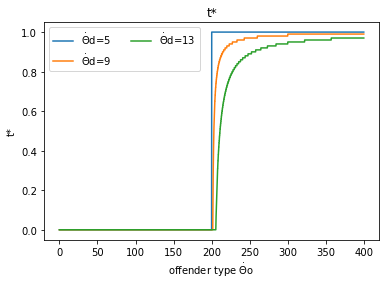

In [32]:
li=np.linspace(0,400,5001)
Z_o_star_5=[]
Z_o_star_9=[]
Z_o_star_13=[]


for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * sample - 400)*(o-o*o/2) + (2 * 5 - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_5.append(temp_id)
    
for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * sample - 400)*(o-o*o/2) + (2 * 9 - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_9.append(temp_id)
    
for sample in li:
    temp_max=0;
    temp_id=0;
    for o in o_frame:
        temp=(2 * sample - 400)*(o-o*o/2) + (2 * 13 - 15)*( 1-o)
        if( temp>temp_max):
            temp_max=temp
            temp_id=o;
    Z_o_star_13.append(temp_id)
        
plt.cla()
plt.plot(li, Z_o_star_5,label="$\dot{\Theta}$d=5")
plt.plot(li, Z_o_star_9,label="$\dot{\Theta}$d=9")
plt.plot(li, Z_o_star_13,label="$\dot{\Theta}$d=13")
plt.title('t*')
plt.xlabel(r"offender type $\dot{\Theta}$o")
plt.ylabel(r't*')
plt.legend(loc=2, ncol=2)
plt.show()